# Ahmet Furkan Ün
# EM1SNO

## Exercise 1a

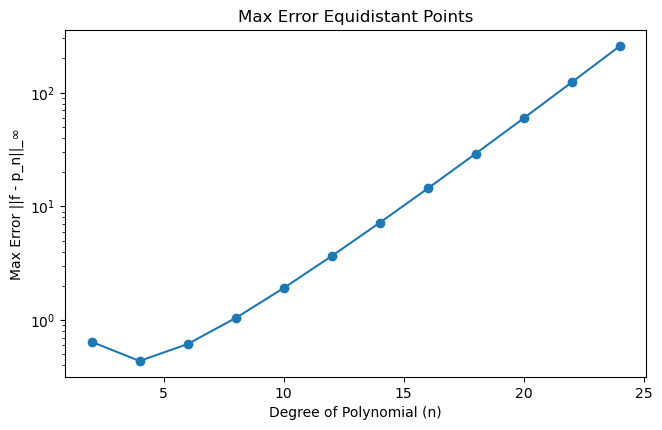

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def lagrange_interpolation(x_points, y_points, x_eval):
    n = len(x_points)
    interpolated_values = np.zeros_like(x_eval, dtype=float)
    for i in range(n):
        L_i = np.ones_like(x_eval, dtype=float)
        for j in range(n):
            if i != j:
                L_i *= (x_eval - x_points[j]) / (x_points[i] - x_points[j])
        interpolated_values += y_points[i] * L_i
    return interpolated_values

def f(x):
    return 1 / (1 + x**2)

a, b = -5, 5
dense_x = np.linspace(a, b, 1000)
f_values = f(dense_x)

errors_equidistant = []

for n in range(2, 25, 2):
    equidistant_x = np.linspace(a, b, n+1)
    equidistant_y = f(equidistant_x)
    equidistant_pn_values = lagrange_interpolation(equidistant_x, equidistant_y, dense_x)
    error_equidistant = np.max(np.abs(f_values - equidistant_pn_values))
    errors_equidistant.append(error_equidistant)

degrees = list(range(2, 25, 2))
plt.figure(figsize=(7.5, 4.5))
plt.plot(degrees, errors_equidistant, 'o-')
plt.xlabel('Degree of Polynomial (n)')
plt.ylabel('Max Error ||f - p_n||_∞')
plt.yscale('log')
plt.title('Max Error Equidistant Points')
plt.show()


## Exercise 1b

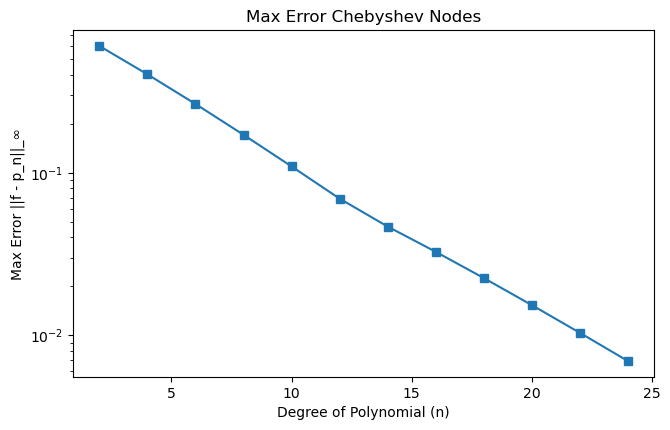

In [5]:
errors_chebyshev = []

for n in range(2, 25, 2):
    chebyshev_x = 0.5 * (b - a) * np.cos((2 * np.arange(1, n+2) - 1) * np.pi / (2 * (n + 1))) + 0.5 * (b + a)
    chebyshev_y = f(chebyshev_x)
    chebyshev_pn_values = lagrange_interpolation(chebyshev_x, chebyshev_y, dense_x)
    error_chebyshev = np.max(np.abs(f_values - chebyshev_pn_values))
    errors_chebyshev.append(error_chebyshev)


degrees = list(range(2, 25, 2))
plt.figure(figsize=(7.5, 4.5))
plt.plot(degrees, errors_chebyshev, 's-')
plt.xlabel('Degree of Polynomial (n)')
plt.ylabel('Max Error ||f - p_n||_∞')
plt.yscale('log')
plt.title('Max Error Chebyshev Nodes')
plt.show()


## Exercise 2

In [7]:
!pip install ipympl

Defaulting to user installation because normal site-packages is not writeable


In [8]:
from matplotlib.animation import FuncAnimation
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"

In [9]:
def linear_spline(x_vals, y_vals, x_interpolate):
    y_interpolate = []
    for x in x_interpolate:
        for i in range(1, len(x_vals)):
            if x_vals[i-1] <= x <= x_vals[i]:
                interp_y = ((x_vals[i] - x) / (x_vals[i] - x_vals[i-1])) * y_vals[i-1] + \
                           ((x - x_vals[i-1]) / (x_vals[i] - x_vals[i-1])) * y_vals[i]
                y_interpolate.append(interp_y)
                break
    return np.array(y_interpolate)

In [10]:
def natural_cubic_spline(x_vals, y_vals, x_interpolate):
    n = len(x_vals) - 1
    h = np.diff(x_vals)
    b = np.diff(y_vals) / h
    
    A = np.zeros((n+1, n+1))
    rhs = np.zeros(n+1)
    
    A[0, 0] = 1
    A[n, n] = 1
    
    for i in range(1, n):
        A[i, i-1] = h[i-1]
        A[i, i] = 2 * (h[i-1] + h[i])
        A[i, i+1] = h[i]
        rhs[i] = 6 * (b[i] - b[i-1])
    
    sigma = np.linalg.solve(A, rhs)
    
    y_interpolate = []
    for x in x_interpolate:
        for i in range(1, len(x_vals)):
            if x_vals[i-1] <= x <= x_vals[i]:
                hi = h[i-1]
                sigma_i_1, sigma_i = sigma[i-1], sigma[i]
                alpha_i = (y_vals[i] / hi) - (sigma_i * hi / 6)
                beta_i = (y_vals[i-1] / hi) - (sigma_i_1 * hi / 6)
                
                interp_y = (
                    ((x_vals[i] - x) ** 3 * sigma_i_1 / (6 * hi)) +
                    ((x - x_vals[i-1]) ** 3 * sigma_i / (6 * hi)) +
                    alpha_i * (x - x_vals[i-1]) +
                    beta_i * (x_vals[i] - x)
                )
                
                y_interpolate.append(interp_y)
                break
    return np.array(y_interpolate)

In [11]:
def hermite_cubic_spline(x_vals, y_vals, dy_vals, x_interpolate):
    def H0(x, xi, xi_1, hi):
        return ((x - xi)**2 / hi**2) * (1 + 2 * (x - xi_1) / hi)
    def K0(x, xi, xi_1, hi):
        return ((x - xi)**2 / hi**2) * (x - xi_1)
    def H1(x, xi, xi_1, hi):
        return ((x - xi_1)**2 / hi**2) * (1 - 2 * (x - xi) / hi)
    def K1(x, xi, xi_1, hi):
        return ((x - xi_1)**2 / hi**2) * (x - xi)
        
    interpolated_values = []
    for x in x_interpolate:
        for i in range(1, len(x_vals)):
            if x_vals[i-1] <= x <= x_vals[i]:
                xi_1, xi = x_vals[i-1], x_vals[i]
                hi = xi - xi_1
                yi_1, yi = y_vals[i-1], y_vals[i]
                dyi_1, dyi = dy_vals[i-1], dy_vals[i]
                
                s = (H0(x, xi, xi_1, hi) * yi_1 +
                     K0(x, xi, xi_1, hi) * dyi_1 +
                     H1(x, xi, xi_1, hi) * yi +
                     K1(x, xi, xi_1, hi) * dyi)
                
                interpolated_values.append(s)
                break
    return np.array(interpolated_values)

In [12]:
def f(x, t):
    return np.sin(5 * np.pi * x) * np.cos(10 * np.pi * t) + 2 * np.sin(7 * np.pi * x) * np.cos(14 * np.pi * t)

def df(x, t):
    return 5 * np.pi * np.cos(5 * np.pi * x) * np.cos(10 * np.pi * t) + 14 * np.pi * np.cos(7 * np.pi * x) * np.cos(14 * np.pi * t)

x_values = np.linspace(0, 1, 51)
t_values = np.linspace(0, 1, 51)
dense_x = np.linspace(0, 1, 500)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
lines = [ax1.plot([], [], lw=2, c='blue')[0],
         ax2.plot([], [], lw=2, c='orange')[0],
         ax3.plot([], [], lw=2, c='green')[0]]


points = [ax1.plot([], [], 'o', markersize=5)[0],  
          ax2.plot([], [], 'o', color='orange', markersize=5)[0],  
          ax3.plot([], [], 'o', color='green', markersize=5)[0]]


for ax, title in zip([ax1, ax2, ax3], ["Linear Spline", "Natural Cubic Spline", "Hermite Cubic Spline"]):
    ax.set_xlim(0, 1)
    ax.set_ylim(-3, 3)
    ax.set_title(title)

def update(frame):
    t = t_values[frame]
    y_vals = f(x_values, t)
    df_y = df(x_values, t)
    
    y_linear = linear_spline(x_values, y_vals, dense_x)
    y_natural_cubic = natural_cubic_spline(x_values, y_vals, dense_x)
    y_hermite_cubic = hermite_cubic_spline(x_values, y_vals, df_y, dense_x)

    lines[0].set_data(dense_x, y_linear)
    lines[1].set_data(dense_x, y_natural_cubic)
    lines[2].set_data(dense_x, y_hermite_cubic)
    
    points[0].set_data(x_values, y_vals)
    points[1].set_data(x_values, y_vals)
    points[2].set_data(x_values, y_vals)
    
    return lines + points

ani = FuncAnimation(fig, update, frames=len(t_values), blit=True, repeat=True)
ani


### Experiment with Less Knots

In [14]:
x_values = np.linspace(0, 1, 11)
t_values = np.linspace(0, 1, 11)
dense_x = np.linspace(0, 1, 500)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
lines = [ax1.plot([], [], lw=2, c='blue')[0],
         ax2.plot([], [], lw=2, c='orange')[0],
         ax3.plot([], [], lw=2, c='green')[0]]

points = [ax1.plot([], [], 'o', markersize=5)[0],  
          ax2.plot([], [], 'o', color='orange', markersize=5)[0],  
          ax3.plot([], [], 'o', color='green', markersize=5)[0]]

for ax, title in zip([ax1, ax2, ax3], ["Linear Spline", "Natural Cubic Spline", "Hermite Cubic Spline"]):
    ax.set_xlim(0, 1)
    ax.set_ylim(-3, 3)
    ax.set_title(title)

ani = FuncAnimation(fig, update, frames=len(t_values), blit=True, repeat=True)
ani
